In [6]:
#%% libraries
import os
import sys
import glob
import itertools
import textract
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# run for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#### Wrappers for textract functions 

In [7]:
#%% reader functions
def pdf_to_txt(inpath, outpath):
    text = textract.process(inpath, method='pdftotext')
    
    base = os.path.abspath(inpath)
    wdir, fname = outpath, os.path.split(base)[1]
    writepath = wdir + '/' + fname.split('.')[0] + '.txt'

    with open(writepath, 'wb') as f:
        f.write(text)

def read_pdf(inpath):
    text = textract.process(inpath, method='pdftotext')
    return text

#### utility functions

In [8]:
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

## Set working directory, Preliminaries

In [9]:
root = '/media/alal/NEPALINEWS/The Kathmandu Post'
os.chdir(root)

#%% directories
input = root 
output = root + '/raw_txts/'

if not os.path.exists(output):
    os.makedirs(output)

%pwd()

'/media/alal/NEPALINEWS/The Kathmandu Post'

*Construct list of files from all subdirectories, store file sizes in dictionary*

In [10]:
pdfs = []
sizes = {}

for root, dirs, files in os.walk(input):
    for file in files:
        if file.endswith(".pdf") and file[0] != '.':
            ff = os.path.join(root, file)
            pdfs.append(ff)
            size = os.path.getsize(ff) # in bytes
            sizes[file] = size

'1010.07 KB'

'395.38 MB'

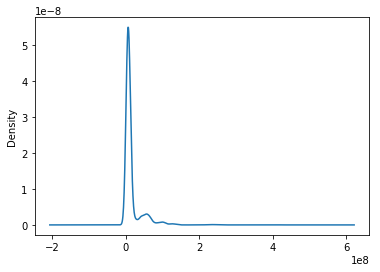

In [11]:
ser = pd.Series(sizes)
ser.plot.density()
convert_size(ser.min())
convert_size(ser.max())

## Bulk convert all pdfs in root - only run once
### Runtime ~= 30 mins

*bulk convert, experimenting with embarrasingly parallel execution*

In [12]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [8]:
%%time
results = Parallel(n_jobs=num_cores)(delayed(pdf_to_txt)(p,output) \
                                     for p in pdfs)

CPU times: user 1.94 s, sys: 300 ms, total: 2.24 s
Wall time: 28min 9s


## Construct word frequencies and write dataframes

In [20]:
# pick file, remove punctuation and stopwords
tmp = '/home/alal/tmp'
inp = '/media/alal/NEPALINEWS/The Kathmandu Post/raw_txts'
out = '/media/alal/NEPALINEWS/The Kathmandu Post/word_frequencies/'

if not os.path.exists(out):
    os.makedirs(out)

In [3]:
def write_word_freqs(inputfile,outdir):
    filterout= set(stopwords.words('english')+
               list(string.punctuation)+
               ['\'\'','``','\'s','’',"“","”",
                'the','said','nepal','world','kathmandu'])
    cols = ['word','freq']

    base = os.path.abspath(inputfile)
    wdir, fname = outdir, os.path.split(base)[1]
    writepath = wdir + '/wfreqs_' + fname.split('.')[0] + '.csv'

    f = open(inputfile)
    raw = f.read()
    tokens = [token.lower() for token in nltk.word_tokenize(raw)]
    cleaned = [token for token in tokens if token not in filterout]
    
    fdict = dict(nltk.FreqDist(cleaned))
    df = pd.DataFrame(list(fdict.items()),columns=cols)
    df = df.sort_values('freq',ascending=0)
    
    df.to_csv(writepath,columns=['word','freq'])

In [5]:
files = glob.glob(inp+'/TKP_*.txt')

*parallelize again * 

In [20]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [10]:
%%time
results = Parallel(n_jobs=num_cores)(delayed(write_word_freqs)(i,out) \
                                     for i in files)

CPU times: user 976 ms, sys: 96 ms, total: 1.07 s
Wall time: 4min 37s


## Search for keywords

In [12]:
def date_stitcher(years, months, days):
    filelist = []
    combinations = list(itertools.product(years, months, days))
    for combination in combinations:
        arguments = "_".join(combination)
        command = 'wfreqs_TKP_' + arguments + '.csv'
        filelist.append(command)
    return filelist


def kw_search(flist, keywords, inpdir, verbose=False):
    freqcols = ['word', 'freq']
    tallies = pd.DataFrame(flist, columns=['file']).set_index('file')
    tallies['exists']=np.nan
    for kw in keywords:
        tallies[kw] = np.nan

    for infile in flist:
        file = inpdir + '/' + infile
        exist_flag = os.path.exists(file)
        if exist_flag:
            tallies.at[infile, 'exists'] = 1
            tkp = pd.read_csv(file, usecols=freqcols, index_col='word')
            for kw in keywords:
                try:
                    a = pd.to_numeric(tkp.loc[kw])
                    tallies.at[infile, kw] = a[0]  # hacky - must be 1 element series
                except:
                    continue
            if verbose: print(infile, 'loaded and searched')
        else:
            tallies.at[infile, 'exists'] = 0
            if verbose: print(infile, ' does not exist')
            continue

    return(tallies)

In [13]:
# preliminaries
working = '/media/alal/NEPALINEWS/The Kathmandu Post'
os.chdir(working)
tmp = '/home/alal/tmp'
inp = '/media/alal/NEPALINEWS/The Kathmandu Post/word_frequencies'

# set up list for date ranges
y = [str(x) for x in range(2007, 2018)]
m = ['{num:02d}'.format(num=x) for x in range(1, 13)]
d = ['{num:02d}'.format(num=x) for x in range(1, 32)]
flist = date_stitcher(y, m, d)
len(flist)

4092

In [14]:
# search all wordcount tables for keyword counts
keywords = ['language', 'bhasa', 'maithili', 'tharu', 'tamang']
tallies = kw_search(flist, keywords, inp)

In [15]:
tallies.shape
nonempty = tallies[(tallies['exists']==1)]
nonempty.shape
nonempty.to_csv(working+'/tallies.csv')

(4092, 6)

(3508, 6)

In [18]:
tallies[150:160]
tallies.isnull().any(axis=1).sum()

,exists,language,bhasa,maithili,tharu,tamang
file,,,,,,
wfreqs_TKP_2007_05_27.csv,1.0,1.0,NaN,NaN,NaN,1.0
wfreqs_TKP_2007_05_28.csv,1.0,2.0,NaN,1.0,NaN,2.0
wfreqs_TKP_2007_05_29.csv,1.0,NaN,NaN,NaN,NaN,2.0
wfreqs_TKP_2007_05_30.csv,1.0,2.0,NaN,NaN,NaN,NaN
wfreqs_TKP_2007_05_31.csv,1.0,2.0,NaN,NaN,NaN,4.0
wfreqs_TKP_2007_06_01.csv,1.0,7.0,NaN,NaN,NaN,NaN
wfreqs_TKP_2007_06_02.csv,1.0,3.0,NaN,NaN,NaN,1.0
wfreqs_TKP_2007_06_03.csv,1.0,6.0,NaN,NaN,NaN,NaN
wfreqs_TKP_2007_06_04.csv,1.0,6.0,NaN,NaN,NaN,1.0


4078